In [9]:
import sys
sys.path.append('../')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import Operator
from torchqc.common_matrices import sigmaZ, annihilation, creation, eye, sigmaPlus, sigmaMinus
from torchqc.dynamics import lindblad_equation
from torchqc.tensor_product import tensor_product_ops, tensor_product_states

* Start from basis state $\psi_0 \otimes \ket{1}$

In [10]:
n = 2 # two level atom
N = 40 # number of fock states
total_dims = n * N
basis_states = QuantumState.basis(n)
atom_state = basis_states[0]

b = np.sqrt(20)*1j
coherent_state = QuantumState.coherent(N, b)
print(coherent_state)

initial_state = tensor_product_states(coherent_state, atom_state)

QuantumState (dims = 40 , tensor: tensor([[ 4.5400e-05+0.0000e+00j],
        [ 0.0000e+00+2.0303e-04j],
        [-6.4205e-04+0.0000e+00j],
        [ 0.0000e+00-1.6578e-03j],
        [ 3.7069e-03+0.0000e+00j],
        [ 0.0000e+00+7.4138e-03j],
        [-1.3536e-02+0.0000e+00j],
        [ 0.0000e+00-2.2879e-02j],
        [ 3.6176e-02+0.0000e+00j],
        [ 0.0000e+00+5.3927e-02j],
        [-7.6265e-02+0.0000e+00j],
        [ 0.0000e+00-1.0284e-01j],
        [ 1.3276e-01+0.0000e+00j],
        [ 0.0000e+00+1.6467e-01j],
        [-1.9682e-01+0.0000e+00j],
        [ 0.0000e+00-2.2726e-01j],
        [ 2.5409e-01+0.0000e+00j],
        [ 0.0000e+00+2.7560e-01j],
        [-2.9051e-01+0.0000e+00j],
        [ 0.0000e+00-2.9805e-01j],
        [ 2.9805e-01+0.0000e+00j],
        [ 0.0000e+00+2.9087e-01j],
        [-2.7733e-01+0.0000e+00j],
        [ 0.0000e+00-2.5861e-01j],
        [ 2.3608e-01+0.0000e+00j],
        [ 0.0000e+00+2.1116e-01j],
        [-1.8520e-01+0.0000e+00j],
        [ 0.0000e+00-

* Simulate dynamics

In [11]:
T = 20
Dt = 0.1
wc = 0.1  # cavity frequency
wa = 0.1  # atom frequency
g = 1  # coupling strength
time = np.arange(0, T, Dt, dtype = np.float32)

* Jaynes-Cummings Hamiltonian under RWA

In [12]:
a_dagger = creation(N)
a = annihilation(N)
sigmap = sigmaPlus()
sigmam = sigmaMinus()

H1 = tensor_product_ops(eye(N), (wa / 2) * sigmaZ())
H2 = tensor_product_ops(wc * a_dagger * a, eye(n))
H3 = g * (tensor_product_ops(a, sigmap) + tensor_product_ops(a_dagger, sigmam))

H = H1 + H2 + H3

In [13]:
matrices = H.matrix.expand(len(time), -1, -1)
hamiltonian = Operator(total_dims, matrices)

* Simulate dynamics with von-Neumann equations

In [14]:
rho = get_density_matrix(initial_state)
jump_operators = [tensor_product_ops(eye(N), sigmam)]
gammas = [0.5]
time_tensor, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_operators, gammas)

In [15]:
N_op = a_dagger * a
expectation_values = expect_val_dm(states, tensor_product_ops(eye(N), sigmaZ()))
expectation_values2 = expect_val_dm(states, tensor_product_ops(N_op, eye(n)))

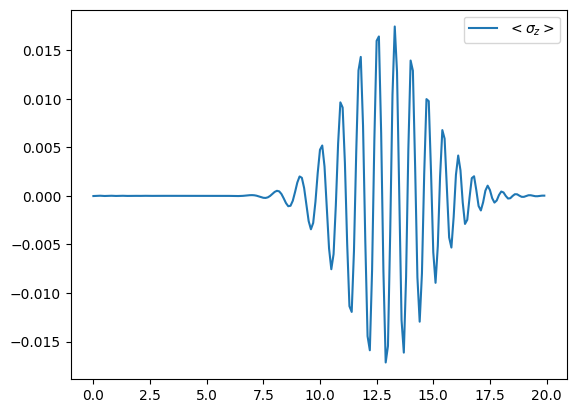

In [16]:
fig, ax = plt.subplots()

plt.plot(time, expectation_values, label=r"$<\sigma_z>$")
ax.legend()